Меркатор

Таблица параллелей (vertical_df):
    Широта (°)    D (см)  От юга (см)  От севера (см)
0          22  1345.087     0.000000        6.948724
1          24  1474.721     0.785290        6.163434
2          26  1606.410     1.583029        5.365694
3          28  1740.384     2.394610        4.554113
4          30  1876.897     3.221572        3.727152
5          32  2016.217     4.065538        2.883186
6          34  2122.727     4.710749        2.237975
7          36  2267.689     5.588892        1.359832
8          38  2416.340     6.489383        0.459341

Таблица меридианов (horizontal_df):
    Долгота (°)  От запада (см)  От востока (см)
0          116         0.00000         5.451975
1          118         0.72693         4.725045
2          120         1.45386         3.998115
3          122         2.18079         3.271185
4          124         2.90772         2.544255
5          126         3.63465         1.817325
6          128         4.36158         1.090395
7          13

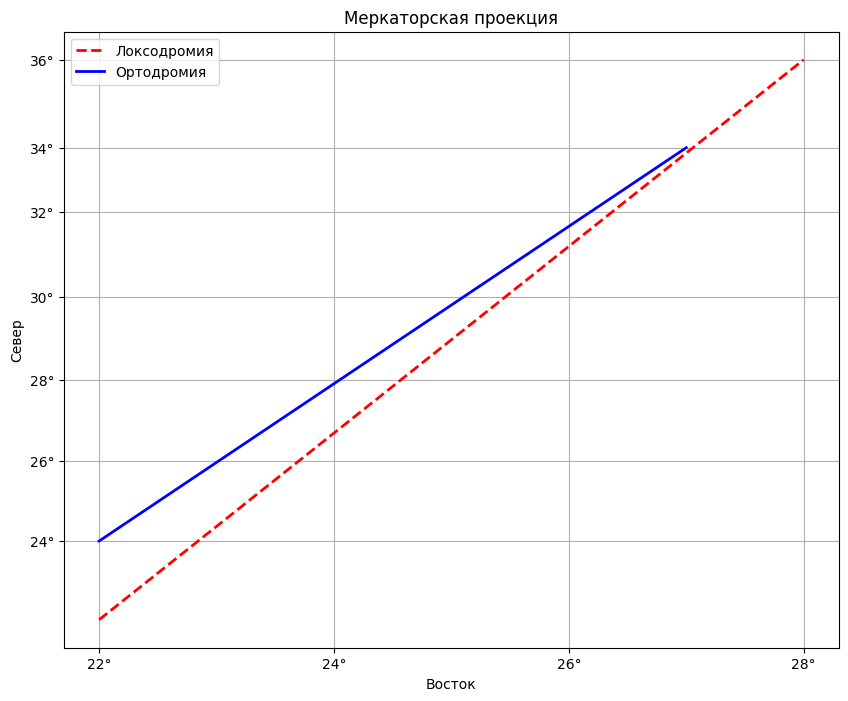

In [4]:

import math
import pandas as pd
import matplotlib.pyplot as plt

##########################
# 1. Входные данные
##########################

rho0 = 60577.5
mu0 = 1 / 10000000
phi_S = 22
phi_N = 39
lambda_W = 116
lambda_E = 131
dphi = 2
dlambda = 2

D_values = {
    22: 1345.087, 23: 1409.661, 24: 1474.721, 25: 1540.294,
    26: 1606.410, 27: 1673.096, 28: 1740.384, 29: 1808.307,
    30: 1876.897, 31: 1946.188, 32: 2016.217, 33: 2087.022,
    34: 2122.727, 35: 2194.769, 36: 2267.689, 37: 2341.530,
    38: 2416.340, 39: 2492.167
}

phi_A = 24
phi_B = 36
lambda_A = 22
lambda_B = 28
R = 6394230
D_A_prime = 1345.087
D_B_prime = 2267.689

##########################
# 2. Расчёты сетки
##########################

phi0 = (phi_S + phi_N) / 2
E = mu0 * rho0
parallels = list(range(phi_S, phi_N + 1, dphi))
meridians = list(range(lambda_W, lambda_E + 1, dlambda))

vertical_data_list = [
    (phi, D_values[phi],
     E * (D_values[phi] - D_values[phi_S]),
     E * (D_values[phi_N] - D_values[phi]))
    for phi in parallels
]

horizontal_data_list = [
    (lam, E * ((lam - lambda_W) * 60), E * ((lambda_E - lam) * 60))
    for lam in meridians
]

vertical_df = pd.DataFrame(vertical_data_list, columns=["Широта (°)", "D (см)", "От юга (см)", "От севера (см)"])
horizontal_df = pd.DataFrame(horizontal_data_list, columns=["Долгота (°)", "От запада (см)", "От востока (см)"])

print("Таблица параллелей (vertical_df):\n", vertical_df)
print("\nТаблица меридианов (horizontal_df):\n", horizontal_df)

##########################
# 3. Расчёты ортодромии и локсодромии
##########################

phi_A_rad = math.radians(phi_A)
phi_B_rad = math.radians(phi_B)
lambda_A_rad = math.radians(lambda_A)
lambda_B_rad = math.radians(lambda_B)

ctg_u = (1 / math.tan(phi_A_rad)) * math.tan(phi_B_rad) * (1 / math.sin(lambda_B_rad - lambda_A_rad)) - (1 / math.tan(lambda_B_rad - lambda_A_rad))
u = math.atan(1 / ctg_u)

lambda_values = []
if lambda_A < lambda_B:
    lambda_values = [math.radians(l) for l in range(lambda_A, lambda_B + 1, 5)]
else:
    lambda_values = [math.radians(l) for l in range(lambda_A, lambda_B - 1, -5)]

phi_ort_values = []

for lambda_i in lambda_values:
    tg_phi_ort = math.tan(phi_A_rad) * (1 / math.sin(u)) * math.sin((u - lambda_A_rad) + lambda_i)
    phi_ort = math.atan(tg_phi_ort)
    phi_ort_values.append(math.degrees(phi_ort))

cos_sigma = math.sin(phi_A_rad) * math.sin(phi_B_rad) + math.cos(phi_A_rad) * math.cos(phi_B_rad) * math.cos(lambda_B_rad - lambda_A_rad)
sigma_rad = math.acos(cos_sigma)
sigma_m = sigma_rad * R
sigma_km = sigma_m / 1000

sin_lambda_diff = math.sin(lambda_B_rad - lambda_A_rad)
cos_lambda_diff = math.cos(lambda_B_rad - lambda_A_rad)
y = sin_lambda_diff * math.cos(phi_B_rad)
x = math.cos(phi_A_rad) * math.sin(phi_B_rad) - math.sin(phi_A_rad) * math.cos(phi_B_rad) * cos_lambda_diff
initial_azimuth_rad = math.atan2(y, x)
initial_azimuth_deg = math.degrees(initial_azimuth_rad)
if initial_azimuth_deg < 0:
    initial_azimuth_deg += 360

if lambda_B < 0:
    lambda_B_corrected = 360 + lambda_B
else:
    lambda_B_corrected = lambda_B

delta_lambda_deg = abs(lambda_B_corrected - lambda_A)
delta_lambda_min = delta_lambda_deg * 60
delta_D_prime = D_B_prime - D_A_prime

loxo_azimuth_rad = math.atan(delta_lambda_min / delta_D_prime)
loxo_azimuth_deg = math.degrees(loxo_azimuth_rad)
if lambda_B_corrected < lambda_A:
    loxo_azimuth_deg = 360 - loxo_azimuth_deg

delta_phi_rad = abs(phi_B_rad - phi_A_rad)
loxo_length = (delta_phi_rad / math.cos(loxo_azimuth_rad)) * R
loxo_length_km = loxo_length / 1000

orthodromy_data = {'Длина (км)': [sigma_km], 'Азимут (градусы)': [initial_azimuth_deg]}
orthodromy_df = pd.DataFrame(orthodromy_data)

loxodromy_data = {'Азимут (градусы)': [loxo_azimuth_deg], 'Длина (км)': [loxo_length_km]}
loxodromy_df = pd.DataFrame(loxodromy_data)

print("\nТаблица ортодромии (orthodromy_df):\n", orthodromy_df)
print("\nТаблица локсодромии (loxodromy_df):\n", loxodromy_df)


##########################
# 4. Визуализация с помощью matplotlib
##########################

# Расчет координат для графика
def correct_longitude(lon):
    return (lon % 360)

# Сетка
x_vals, y_vals = [], []

# Создание графика
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Меркаторская проекция")
ax.set_xlabel("Восток")
ax.set_ylabel("Север")

# Убираем отрисовку "старой" сетки
#ax.plot([0, (lambda_E - lambda_W) * 60 * E], [from_south, from_south], color='lightgray', linewidth=0.5)
#ax.plot([from_west, from_west], [0, (D_values[phi_N] - D_values[phi_S]) * E], color='lightgray', linewidth=0.5)

# Локсодромия
lambda_A_corrected = correct_longitude(lambda_A)
lambda_B_corrected = correct_longitude(lambda_B)

x1_raw = (lambda_A_corrected - lambda_W) * 60 * E
y1_raw = (D_A_prime - D_values[phi_S]) * E
x2_raw = (lambda_B_corrected - lambda_W) * 60 * E
y2_raw = (D_B_prime - D_values[phi_S]) * E

ax.plot([x1_raw, x2_raw], [y1_raw, y2_raw], color='red', linestyle='--', linewidth=2, label='Локсодромия')

# Ортодромия
ortho_x = []
ortho_y = []
for lam_rad, phi in zip(lambda_values, phi_ort_values):
    lam_deg = math.degrees(lam_rad)
    lam_deg_corrected = correct_longitude(lam_deg)
    x_raw = (lam_deg_corrected - lambda_W) * 60 * E
    y_raw = (D_values[round(phi)] - D_values[phi_S]) * E
    ortho_x.append(x_raw)
    ortho_y.append(y_raw)

ax.plot(ortho_x, ortho_y, color='blue', linewidth=2, label='Ортодромия')

ax.legend()

# Настройка сетки с градусами
xticks = []
xlabels = []
for lam in range(lambda_A, lambda_B + 1, 2):
    lam_corrected = correct_longitude(lam)
    x = (lam_corrected - lambda_W) * 60 * E
    xticks.append(x)
    xlabels.append(str(lam) + "°")

yticks = []
ylabels = []
for phi in range(phi_A, phi_B + 1, 2):
    y = (D_values[phi] - D_values[phi_S]) * E
    yticks.append(y)
    ylabels.append(str(phi) + "°")

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)

ax.grid(True) # Добавляем сетку, но теперь на основе заданных координат


plt.show()


Расчет и построение сетки

In [7]:
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

# Параметры проекции
R = 6371  # Радиус Земли в км
north, south = 65, 77  # Границы по широте
west, east = 126, 132  # Границы по долготе

# Основные параметры проекции
phi_0 = (north + south) / 2
lam_0 = (west + east) / 2
alpha = sp.sin(sp.rad(phi_0)).evalf()
r_0 = (R * sp.cos(sp.rad(phi_0))).evalf()
c = (r_0 / (sp.tan(sp.rad(45) + sp.rad(phi_0) / 2) - alpha) / alpha).evalf()  

# Широты для расчета
phi_values = [65, 66, 67, 68, 69, 70, 71, 72]

# Расчет значений ρ
rho_values = [(c * (sp.tan(sp.rad(45) + sp.rad(phi) / 2) - alpha)).evalf() for phi in phi_values]  # 

rho_values_maschtab = [rho / 25 for rho in rho_values]
lam_value = 2
delta = (alpha * lam_value).evalf()

q = max(rho_values_maschtab)
xy_values = [(phi, (q - rho * sp.cos(sp.rad(delta))).evalf(),
             (rho * sp.sin(sp.rad(delta))).evalf())
             for phi, rho in zip(phi_values, rho_values_maschtab)]

mn_values = [(phi, (alpha * rho / (R * sp.cos(sp.rad(phi))).evalf()))
             for phi, rho in zip(phi_values, rho_values)]

results_df = pd.DataFrame({
    'Широта φ, °': phi_values,
    'ρ, км': [rho for rho in rho_values],
    'ρ (масштаб 1:2.5M)': [rho_m for rho_m in rho_values_maschtab],
    'x, см': [x for _, x, _ in xy_values],
    'y, см': [y for _, _, y in xy_values],
    'm = n': [mn for _, mn in mn_values]
})

results_df['ρ, км'] = results_df['ρ, км'].apply(lambda x: f"{x:.2f}")
results_df['ρ (масштаб 1:2.5M)'] = results_df['ρ (масштаб 1:2.5M)'].apply(lambda x: f"{x:.2f}")
results_df['x, см'] = results_df['x, см'].apply(lambda x: f"{x:.2f}")
results_df['y, см'] = results_df['y, см'].apply(lambda x: f"{x:.2f}")
results_df['m = n'] = results_df['m = n'].apply(lambda x: f"{x:.6f}")


# Основные параметры проекции
params_df = pd.DataFrame({
    'Параметр': ['φ₀', 'λ₀', 'α', 'r₀', 'c', 'δ'],
    'Значение': [
        f"{phi_0}°",
        f"{lam_0}°",
        f"{alpha:.6f}",
        f"{r_0:.2f} км",
        f"{c:.2f}",
        f"{delta:.6f}"
    ]
})

print("Основные параметры проекции:")
print(params_df.to_string(index=False))
print("\nРезультаты расчетов:")
print(results_df.to_string(index=False))

# Визуализация координат
plt.figure(figsize=(10, 6))
plt.title('Координаты в проекции')
x_coords = [float(x) for _, x, _ in xy_values]
y_coords = [float(y) for _, _, y in xy_values]
plt.scatter(x_coords, y_coords)
for phi, x, y in xy_values:
    plt.text(float(x), float(y), f"{phi}°", fontsize=9, ha='right')
plt.xlabel('x, см')
plt.ylabel('y, см')
plt.grid(True)
plt.show()

Основные параметры проекции:
Параметр   Значение
      φ₀      71.0°
      λ₀     129.0°
       α   0.945519
      r₀ 2074.19 км
       c     436.10
       δ   1.891037

Результаты расчетов:
 Широта φ, °   ρ, км ρ (масштаб 1:2.5M) x, см y, см    m = n
          65 1554.79              62.19 31.49  2.05 0.545993
          66 1639.36              65.57 28.11  2.16 0.598170
          67 1731.18              69.25 24.44  2.29 0.657545
          68 1831.22              73.25 20.44  2.42 0.725482
          69 1940.66              77.63 16.06  2.56 0.803680
          70 2060.93              82.44 11.25  2.72 0.894279
          71 2193.71              87.75  5.94  2.90 1.000000
          72 2341.11              93.64  0.05  3.09 1.124350


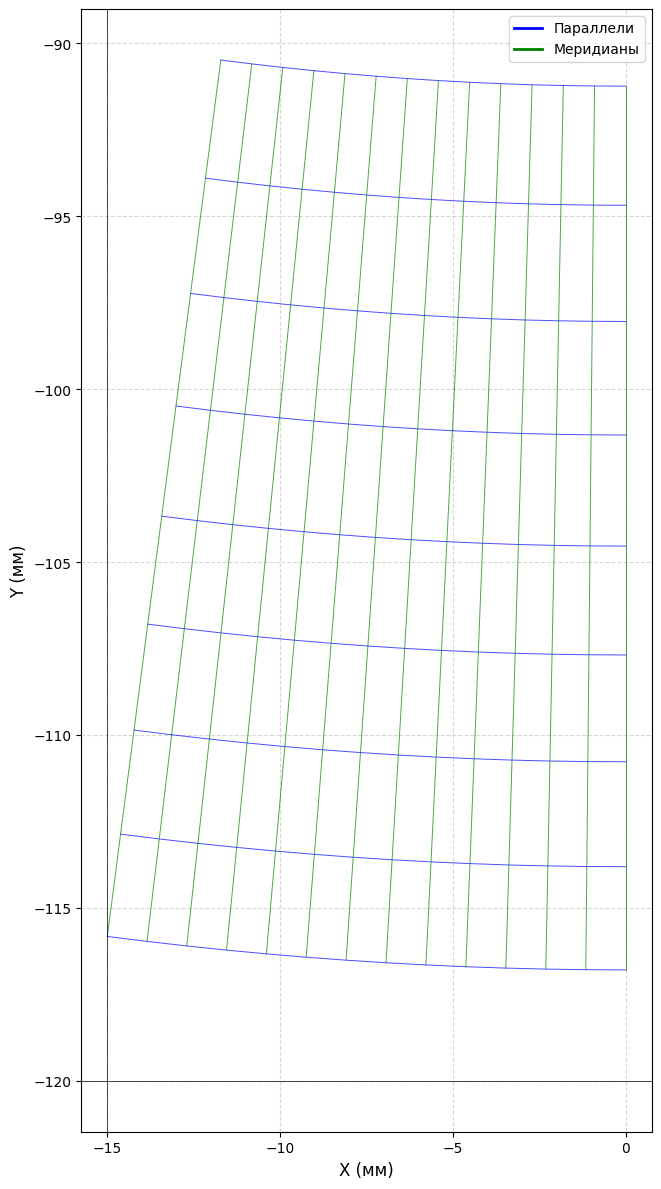

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

phi_0 = 71  
lam_0 = 129  
alpha = 0.945519
r_0 = 2074.19
c = 436.10

scale_factor = 50  

def calculate_rho(phi):
    return c / (np.tan(np.radians(45) + np.radians(phi)/2)**alpha)

# Функция перевода в мм
def project(phi, lam):
    rho = calculate_rho(phi) / scale_factor
    delta = alpha * np.radians(lam - lam_0)
    x = rho * np.sin(delta)
    y = -rho * np.cos(delta)  
    return x, y

# Создаем фигуру
plt.figure(figsize=(12, 12))
ax = plt.gca()

# Диапазоны для сетки 
latitudes = np.arange(67, 76, 1)  
longitudes = np.arange(62, 76, 1)  

# Рисуем параллели (широты)
for phi in latitudes:
    x_vals = []
    y_vals = []
    for lam in longitudes:
        x, y = project(phi, lam)
        x_vals.append(x)
        y_vals.append(y)
    ax.plot(x_vals, y_vals, 'b-', linewidth=0.7, alpha=0.7)

# Рисуем меридианы (долготы)
for lam in longitudes:
    x_vals = []
    y_vals = []
    for phi in latitudes:
        x, y = project(phi, lam)
        x_vals.append(x)
        y_vals.append(y)
    ax.plot(x_vals, y_vals, 'g-', linewidth=0.7, alpha=0.7)


# Настройки графика
ax.set_xlabel("X (мм)", fontsize=12)
ax.set_ylabel("Y (мм)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.axhline(-120, color='black', linewidth=0.5)
ax.axvline(-15, color='black', linewidth=0.5)
ax.set_aspect('equal')

# Настраиваем сетку с шагом 5 мм
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(5))

# Добавляем легенду
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Параллели'),
    plt.Line2D([0], [0], color='green', lw=2, label='Меридианы')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

Гномическ.

In [1]:
import pandas as pd
import math

phi_0_deg = 56
lambda_0_deg = 159
scale = 1 / 20000000
M_0 = 10**6.8047303
N_0 = 10**6.8022937
R = math.sqrt(M_0 * N_0)

def deg2rad(deg):
    return math.radians(deg)

def compute_row(phi_deg, lambda_deg):
    phi = deg2rad(phi_deg)
    lam = deg2rad(lambda_deg)
    phi_0 = deg2rad(phi_0_deg)
    lam_0 = deg2rad(lambda_0_deg)

    lam_diff = lambda_deg - lambda_0_deg
    cos_phi0_sin_phi = math.cos(phi_0) * math.sin(phi)
    sin_phi0_cos_phi_cos = math.sin(phi_0) * math.cos(phi) * math.cos(lam - lam_0)
    xi = cos_phi0_sin_phi - sin_phi0_cos_phi_cos
    eta = math.cos(phi) * math.sin(lam - lam_0)
    zeta = math.sin(phi_0) * math.sin(phi) + math.cos(phi_0) * math.cos(phi) * math.cos(lam - lam_0)
    sec_z = 1 / zeta
    rho = scale * R * math.tan(math.acos(zeta))
    x = scale * R * xi * sec_z
    y = scale * R * eta * sec_z
    mu1 = sec_z ** 2
    mu2 = sec_z
    p = mu1 * mu2
    tg_omega_4 = math.sqrt(sec_z)
    omega_rad = 4 * (math.atan(tg_omega_4) - math.radians(45))
    omega_deg = math.degrees(omega_rad)

    return [
        phi_deg, lambda_deg, lam_diff,
        cos_phi0_sin_phi, sin_phi0_cos_phi_cos,
        xi, eta,
        math.sin(phi_0) * math.sin(phi), math.cos(phi_0) * math.cos(phi) * math.cos(lam - lam_0),
        zeta, sec_z, scale * R * sec_z,
        x, y, mu1, mu2, p, tg_omega_4, omega_deg
    ]

headers = [
    "φ", "λ", "λ−λ₀", "cosφ₀sinφ", "sinφ₀cosφcos(λ−λ₀)",
    "ξ", "η", "sinφ₀sinφ", "cosφ₀cosφcos(λ−λ₀)", "ζ", "sec z", "μ₀R sec z",
    "x, м", "y, м", "μ₁", "μ₂", "p", "tg(45°+ω/4)", "ω°"
]

latitudes = [55, 65, 75]
longitudes = [0, 10, 20, 30, 40, 50]

grid_points = []
for phi in latitudes:
    for lam in longitudes:
        grid_points.append(compute_row(phi, lam))

# Create Pandas DataFrame
df = pd.DataFrame(grid_points, columns=headers)

# Format float columns to 4 decimal places
float_cols = df.select_dtypes(include=['float']).columns
df[float_cols] = df[float_cols].applymap("{:.4f}".format)

print(df)

# Optional: Save to CSV or Excel
# df.to_csv("gnomonic_projection.csv", index=False)
# df.to_excel("gnomonic_projection.xlsx", index=False)


     φ   λ  λ−λ₀ cosφ₀sinφ sinφ₀cosφcos(λ−λ₀)       ξ        η sinφ₀sinφ  \
0   55   0  -159    0.4581            -0.4439  0.9020  -0.2056    0.6791   
1   55  10  -149    0.4581            -0.4076  0.8657  -0.2954    0.6791   
2   55  20  -139    0.4581            -0.3589  0.8169  -0.3763    0.6791   
3   55  30  -129    0.4581            -0.2993  0.7573  -0.4458    0.6791   
4   55  40  -119    0.4581            -0.2305  0.6886  -0.5017    0.6791   
5   55  50  -109    0.4581            -0.1548  0.6129  -0.5423    0.6791   
6   65   0  -159    0.5068            -0.3271  0.8339  -0.1515    0.7514   
7   65  10  -149    0.5068            -0.3003  0.8071  -0.2177    0.7514   
8   65  20  -139    0.5068            -0.2644  0.7712  -0.2773    0.7514   
9   65  30  -129    0.5068            -0.2205  0.7273  -0.3284    0.7514   
10  65  40  -119    0.5068            -0.1699  0.6767  -0.3696    0.7514   
11  65  50  -109    0.5068            -0.1141  0.6209  -0.3996    0.7514   
12  75   0  

C:\Users\matve\AppData\Local\Temp\ipykernel_20648\4277268998.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[float_cols] = df[float_cols].applymap("{:.4f}".format)


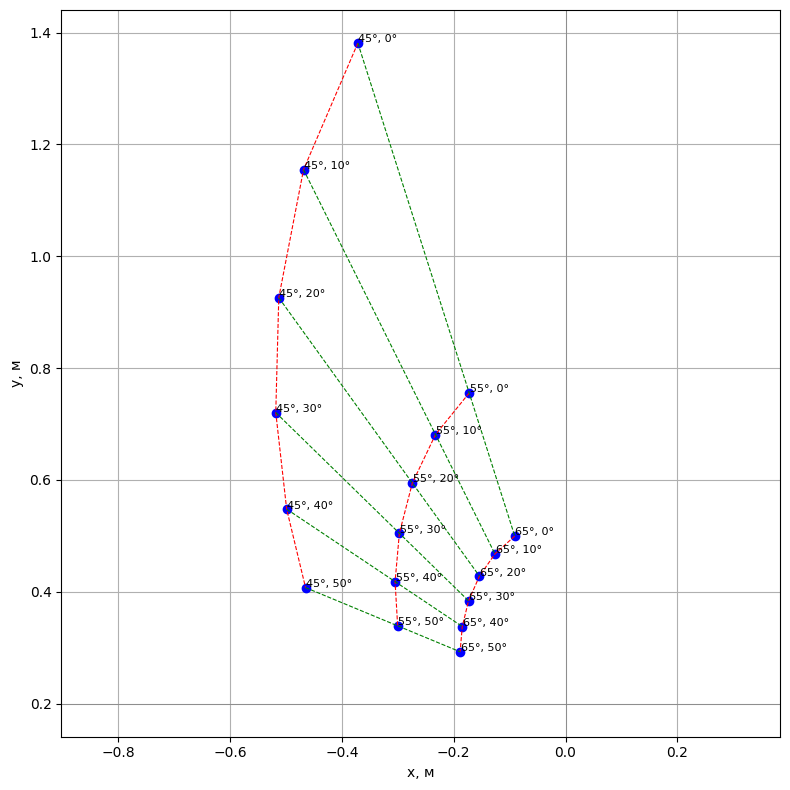

In [4]:
import math
import matplotlib.pyplot as plt
phi_0_deg = 56
lambda_0_deg = 159
scale = 1 / 20000000
M_0 = 10**6.8047303
N_0 = 10**6.8022937
R = math.sqrt(M_0 * N_0)

def deg2rad(deg):
    return math.radians(deg)

def gnomonic_projection(phi_deg, lambda_deg):
    phi = deg2rad(phi_deg)
    lam = deg2rad(lambda_deg)
    phi_0 = deg2rad(phi_0_deg)
    lam_0 = deg2rad(lambda_0_deg)

    xi = math.cos(phi_0) * math.sin(phi) - math.sin(phi_0) * math.cos(phi) * math.cos(lam - lam_0)
    eta = math.cos(phi) * math.sin(lam - lam_0)
    zeta = math.sin(phi_0) * math.sin(phi) + math.cos(phi_0) * math.cos(phi) * math.cos(lam - lam_0)
    sec_z = 1 / zeta

    y = scale * R * xi * sec_z
    x = scale * R * eta * sec_z

    return x, y

latitudes = [45, 55, 65 ]
longitudes = [0, 10, 20, 30, 40, 50]

points = [(phi, lam, *gnomonic_projection(phi, lam)) for phi in latitudes for lam in longitudes]

plt.figure(figsize=(8, 8))

for phi, lam, x, y in points:
    plt.plot(x, y, 'bo')
    plt.text(x + 0.001, y + 0.001, f"{phi}°, {lam}°", fontsize=8)

for phi in latitudes:
    x_vals = []
    y_vals = []
    for lam in longitudes:
        x, y = gnomonic_projection(phi, lam)
        x_vals.append(x)
        y_vals.append(y)
    plt.plot(x_vals, y_vals, 'r--', linewidth=0.8)

for lam in longitudes:
    x_vals = []
    y_vals = []
    for phi in latitudes:
        x, y = gnomonic_projection(phi, lam)
        x_vals.append(x)
        y_vals.append(y)
    plt.plot(x_vals, y_vals, 'g--', linewidth=0.8)

plt.axhline(0.2, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.xlabel("x, м")
plt.ylabel("y, м")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()